# Behavioural Cloning

Train vehicles to drive autonomously, using data recorded from my own driving

---

In [1]:
# Imports
import os
import csv
import math
import random

import cv2
import pickle
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from keras.models import Sequential, Model
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Dropout, Flatten, Lambda, ELU, MaxPooling2D
from keras.regularizers import l2, activity_l2
from keras.optimizers import Adam
from keras.layers.convolutional import Convolution2D

import matplotlib.pyplot as plt
%matplotlib inline

# random.seed(137)
# np.random.seed(137)

Using TensorFlow backend.


## Load and simple exploration

In [2]:
# TRAINING_DIR = "/home/carnd/CarND-Behavioral-Cloning-P3/Training Data/"
TRAINING_DIR = "/Users/Mango/Documents/Development/Learning Plus Challenges/SDC/Term 1/CarND-Behavioral-Cloning-P3/Training Data/"

def load_data(file_path):
    X_data = []
    y_data = []
    with open(TRAINING_DIR + file_path) as logs:
        img_col, steering_col, speed_col = 0, 3, 6
        for log in csv.reader(logs):
            path = log[img_col]
            # path = path.replace('/Users/Mango/Documents/Development/Learning Plus Challenges/SDC/Term 1/', '/home/carnd/')
            try:
                # undersample data of straight driving
                if float(log[speed_col]) < 0.001:
                    continue
                X_data.append(path)
                y_data.append(float(log[steering_col]))
            except ValueError:
                pass
    return np.array(X_data), np.array(y_data)

X_data, y_data = load_data('driving_log.csv')
X_recover, y_recover = load_data('recovery/driving_log.csv')

print(len(y_data), '+', len(y_recover), '=', len(np.append(y_data, y_recover)), "logs found")

12498 + 3261 = 15759 logs found


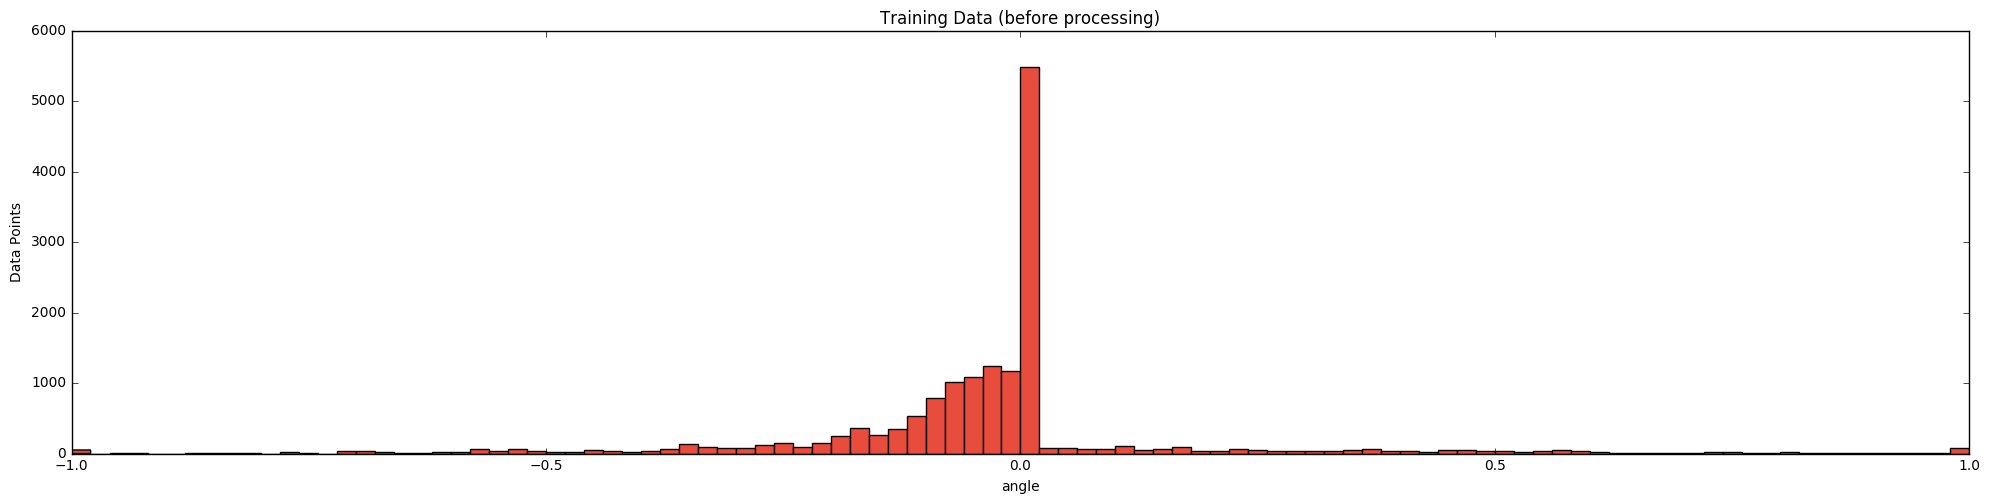

In [3]:
# Visualize Data
def generate_graph(y_data, x_label='angle', y_label='Data Points', title='', bins=100):
    fig, ax = plt.subplots(figsize=(20, 5))
    n, bins, patches = ax.hist(y_data, bins=bins, range=(-1,1), color="#E74C3C", alpha=1.0)
#     n, bins, patches = ax.hist(moving_average(y_data), bins=100, range=(-1.0,1.0), color="#2C3E50", alpha=0.75)
    ax.set_xlabel('Angle')
    ax.set_ylabel('Data Points')
    fig.tight_layout()
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(title)
    
generate_graph(np.append(y_data, y_recover), title='Training Data (before processing)')

## Augment and Preprocess Data

In [4]:
# Preprocess Data

TRANS_RANGE = 100

def read_img(img_path, augmented=False):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    if augmented:
        return img
    return img#[55:140]


def write_img(img, img_path):
    img = cv2.cvtColor(img,cv2.COLOR_RGB2BGR)
    return cv2.imwrite(img_path, img)


def augment_flip(img, steering_angle, force=False):
    if random.getrandbits(1) or force:
        img = cv2.flip(img,1)
        steering_angle *= -1
    return img, steering_angle


def augment_translation(img, steering):
    rows, cols, _ = img.shape
    t_x = TRANS_RANGE*np.random.uniform()-TRANS_RANGE/2
    
    steering = steering + t_x/TRANS_RANGE*2*.2
    
    Trans_M = np.float32([[1,0,t_x],[0,1,0]])
    image_tr = cv2.warpAffine(img,Trans_M,(cols,rows))
    
    return image_tr, steering, t_x/TRANS_RANGE*2*.2


def augment_brightness_and_shadow(img):
    img, bright = augment_brightness(img)
    min_shade = .5
    # shadow part is never less than min_shade of total, max is always 100%
    random_bright = min_shade/bright + np.random.uniform()*(1-min_shade/bright)
    
    return augment_shadow(img, random_bright)


def augment_brightness(img):
    random_bright = .5+np.random.uniform()*0.5 # between 50% and 100%
    
    # Works better in HSV colorspace
    img_hsv = cv2.cvtColor(img,cv2.COLOR_RGB2HSV)
    img_hsv[:,:,2] = img_hsv[:,:,2]*random_bright
    
    return cv2.cvtColor(img_hsv,cv2.COLOR_HSV2RGB), random_bright


def augment_shadow(img, brightness):
    rows, cols, _ = img.shape
    top_y = cols*np.random.uniform()
    top_x = 0
    bot_x = rows
    bot_y = cols*np.random.uniform()
    image_hsv = cv2.cvtColor(img,cv2.COLOR_RGB2HSV)
    shadow_mask = 0*image_hsv[:,:,2]
    X_m = np.mgrid[0:rows, 0:cols][0]
    Y_m = np.mgrid[0:rows, 0:cols][1]
    shadow_mask[((X_m-top_x)*(bot_y-top_y) -(bot_x - top_x)*(Y_m-top_y) >=0)]=1
    
    cond = shadow_mask == random.getrandbits(1)
    image_hsv[:,:,2][cond] = image_hsv[:,:,2][cond]*brightness  
    
    return cv2.cvtColor(image_hsv,cv2.COLOR_HSV2RGB)


def moving_average(data, n=3):
    """
    Calculate moving average
    http://stackoverflow.com/a/14314054
    """
    if n==1 or len(data) < n:
        return data
    
    ma = np.cumsum(data, dtype=float)
    ma[n:] = ma[n:] - ma[:-n]
    return np.append(ma[:n - 1], ma[n - 1:] / n)


def augment_image(img, steering, metadata=None):
    steering_old = steering
    img, steering = augment_flip(img, steering)
    flipped = steering != steering_old
    img, steering, t_x = augment_translation(img, steering)
    
    img = augment_brightness_and_shadow(img)
    if metadata is None:
        return img, steering, t_x
    return img, steering, (metadata, flipped, t_x)

(12498, 3261)

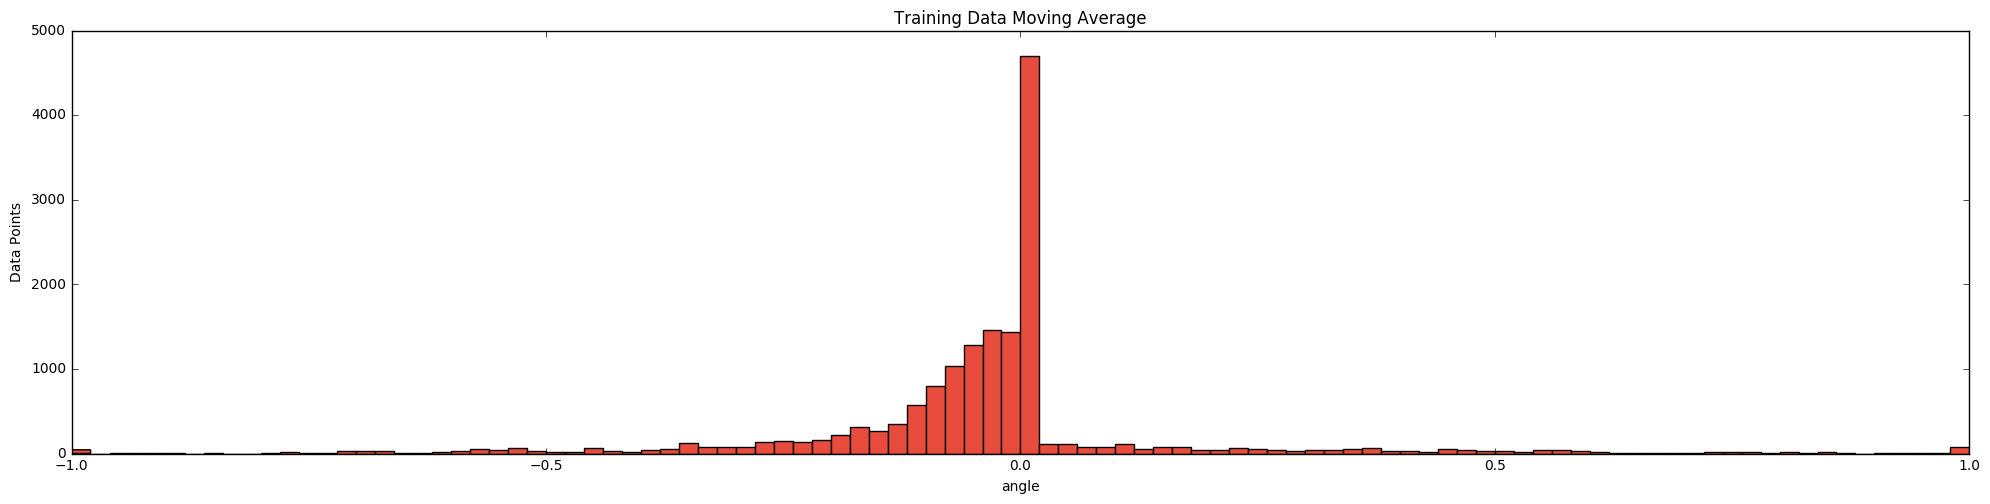

In [5]:
# Preprocessing Part 1
X_orig_data, y_orig_ma = np.concatenate((X_data, X_recover), axis=0), np.concatenate((y_data_ma, y_recover_ma), axis=0)
X_train, X_valid, y_train, y_valid = train_test_split(X_orig_data, y_orig_ma, train_size=0.75)

y_data_ma = moving_average(y_train)
y_recover_ma = moving_average(y_recover) # just curious
generate_graph(y_data_ma + y_recover_ma, title='Training Data Moving Average')
len(y_data), len(y_recover)

10523


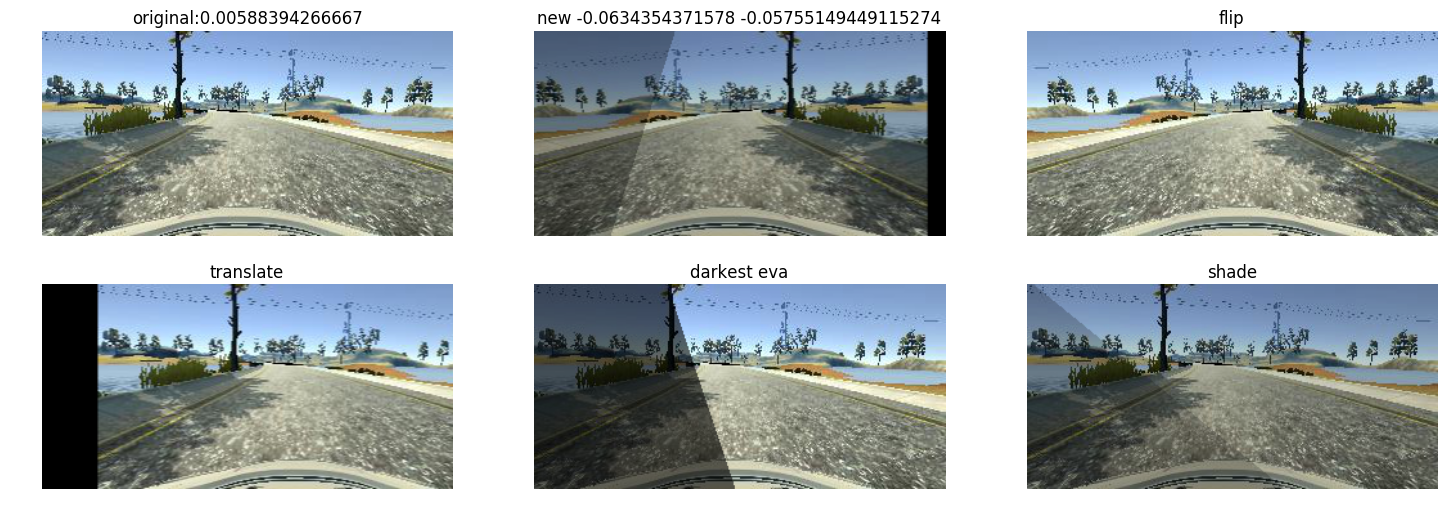

In [6]:
# Preprocessing Part 2
def compare_images(images, rows=2, cols=None, figsize=None):
    img_count = len(images)
    if cols is None:
        cols = img_count
    if figsize is None:
        figsize=(3*len(images), 6)
    fig, axs = plt.subplots(rows, cols, figsize=figsize)
    for row in range(len(axs)):
        colsize = len(axs[row])
        for col in range(colsize):
            index = colsize*row + col
            axs[row][col].axis('off')
            axs[row][col].set_title(images[index][0])
            axs[row][col].imshow(images[index][1].squeeze())


index = random.randint(0, len(X_train)-1) # 28th
print(index)
o_img, o_lbl = read_img(X_train[index]), y_data_ma[index]

aug_img, steer, t_x = augment_image(o_img, o_lbl)

images = [
    ('original:' + str(o_lbl), o_img),
    ('new ' + str(steer) + ' ' + str(t_x),      aug_img),
    ('flip',                   augment_flip(o_img, o_lbl)[0]),
    ('translate',              augment_translation(o_img, o_lbl)[0]),
    ('darkest eva',             augment_shadow(o_img, .4)),
    ('shade',                  augment_brightness_and_shadow(o_img)),
]

compare_images(images, 2, 3)

## Augment and Resample Images

In [7]:
# Augment Data
X_data_aug = []
y_data_aug = []

SAMPLE_SIZE = 2000

img_metadata = {}

if not os.path.exists(TRAINING_DIR + 'augmented_log.csv'):
    print("Files not found, generating images...", flush=True)
    
    # Generate flipped images
    for i in range(len(X_train)):
        x, y = read_img(X_train[i]), y_train[i]
        X_data_aug.append((x,len(img_metadata)))
        y_data_aug.append(y)
        img_metadata[len(img_metadata)] = ('original',)
        x2, y2 = augment_flip(x,y,True)
        X_data_aug.append((x2,len(img_metadata)))
        y_data_aug.append(y2)
        img_metadata[len(img_metadata)] = ('flipped',)

    X_data_aug, y_data_aug = np.asarray(X_data_aug), np.asarray(y_data_aug)

    print(y_orig_ma.shape)
    print("Flipped images created", flush=True)
    for _ in range(3):
        for i in np.arange(-1,1,0.1):
            count = len(np.where((i <= y_data_aug) & (y_data_aug <= i + 0.1))[0])
            sample_size = SAMPLE_SIZE * 1.1
            if count >= sample_size:
                continue
            print("\nGenerating data for section", i, "-", i + 0.1, ': ', end='', flush=True)
            c = 0
            while len(np.where((i <= y_data_aug) & (y_data_aug <= i + 0.1))[0]) < sample_size:
                indexes = np.where((i <= y_orig_ma) & (y_orig_ma <= i + 0.1))[0]
                if len(indexes) == 0:
                    continue
                index = random.choice(indexes)
                x, y, metadata = None, -10, None
                while not ((i <= y) and (y <= i + 0.1)):
                    x, y = read_img(X_orig_data[index]), y_orig_ma[index]
                    x, y, metadata = augment_image(x, y, metadata=X_orig_data[index])
                X_data_aug = np.concatenate((X_data_aug, [(x, len(img_metadata))]), axis=0)
                y_data_aug = np.concatenate((y_data_aug, [y]), axis=0)
                img_metadata[len(img_metadata)] = metadata

                if c % 1000 == 0:
                    print(c, end='', flush=True)
                elif c % 100 == 0:
                    print('|', end='', flush=True)
                c += 1

        X_data_aug = X_data_aug[np.where(y_data_aug < 1)]
        y_data_aug = y_data_aug[np.where(y_data_aug < 1)]
    
    for i in np.arange(-1,1,0.1):
        indexes = np.where((i <= y_data_aug) & (y_data_aug < i + 0.1))[0]
        count = len(indexes)
        if count > SAMPLE_SIZE:
            np.random.shuffle(indexes)
            indexes = indexes[SAMPLE_SIZE:]
            X_data_aug = np.delete(X_data_aug, indexes, axis=0)
            y_data_aug = np.delete(y_data_aug, indexes, axis=0)
    
    print(len(X_data_aug), len(y_data_aug))
    
    print('', flush=True)
    print("Saving Random Order...", len(X_data_aug), flush=True)
    csv_data = []
    X_data_aug, y_data_aug = shuffle(X_data_aug, y_data_aug)
    os.makedirs(TRAINING_DIR + 'IMG_augmented/')
    for i in range(len(X_data_aug)):
        path = TRAINING_DIR + 'IMG_augmented/{0:05d}'.format(i)+'.jpg'
        write_img(X_data_aug[i][0], path)
        
        metadata = img_metadata[X_data_aug[i][1]]
        csv_data.append([path, y_data_aug[i], *metadata])
    
    print("Saved images", flush=True)
    with open(TRAINING_DIR + 'augmented_log.csv', 'w') as f:
        csv_writer = csv.writer(f)
        csv_writer.writerows(csv_data)
    print("Done Saving!", flush=True)

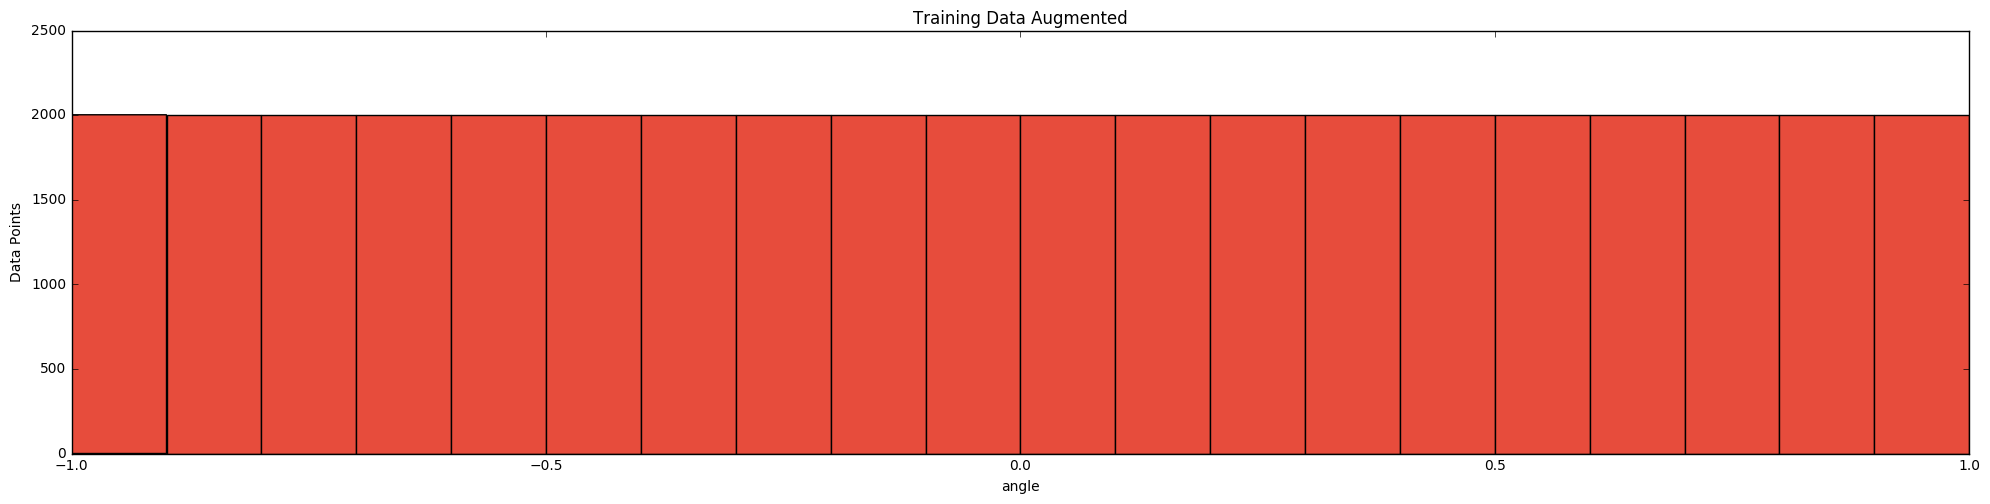

In [8]:
# Load and Visualize Augmented Data
X_data_aug = []
y_data_aug = []

with open(TRAINING_DIR + 'augmented_log.csv', 'r') as logs:
    for log in csv.reader(logs):
        X_data_aug.append(log[0])
        y_data_aug.append(float(log[1]))
        
generate_graph(y_data_aug, title='Training Data Augmented', bins=20)

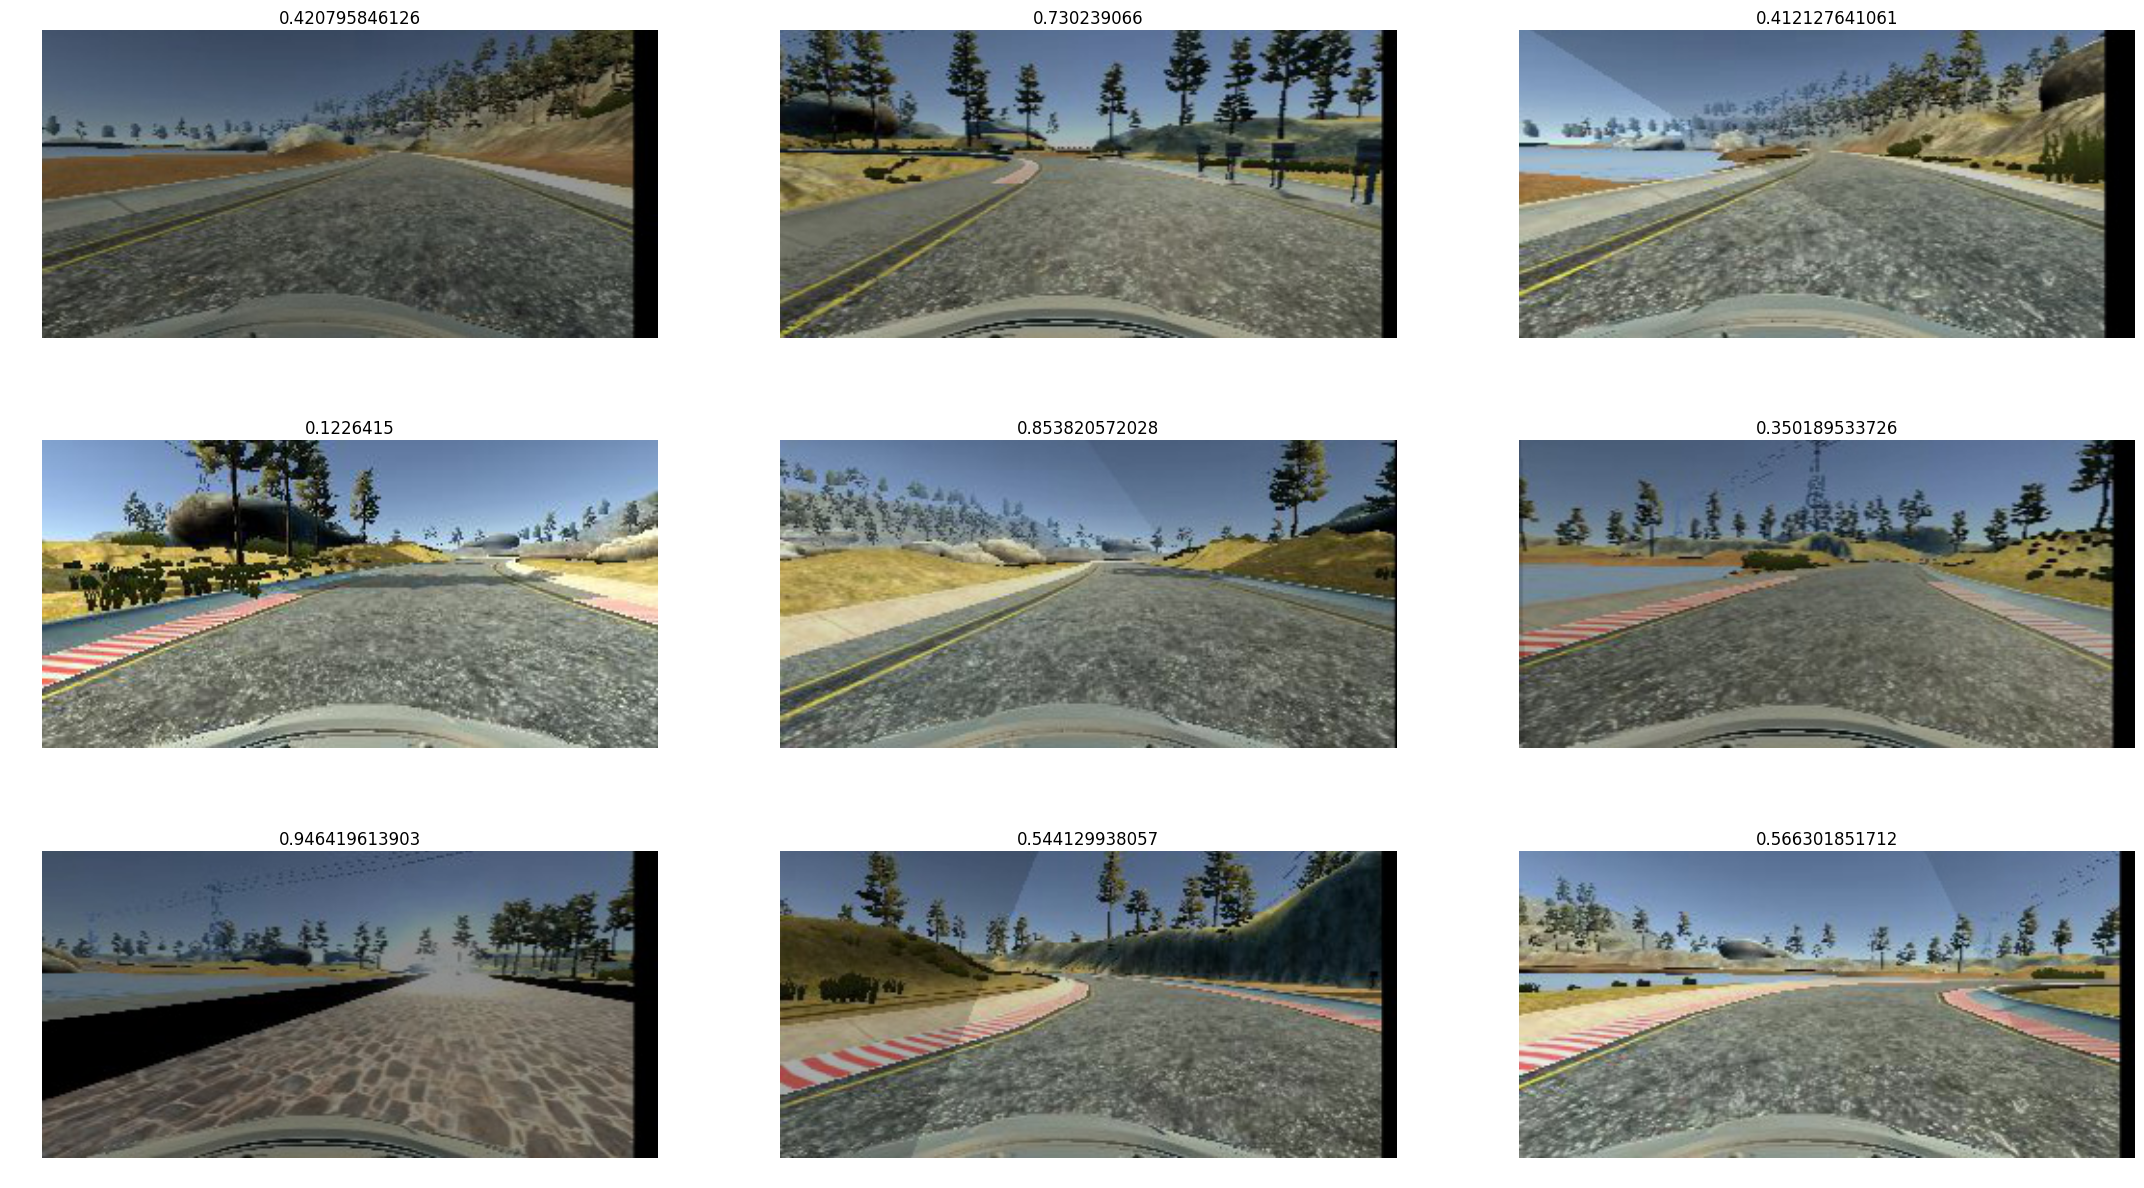

In [9]:
indexes = np.where((0 < np.asarray(y_data_aug)) & (np.asarray(y_data_aug) < 0.99))[0]
pics = []
for _ in range(9):
    i = random.choice(indexes)
    img_path = X_data_aug[i]#.replace('/Users/Mango/Documents/Development/Learning Plus Challenges/SDC/Term 1/', '/home/carnd/')
    pics.append((str(y_data_aug[i]), read_img(img_path, True)))
compare_images(pics, 3, 3, figsize=(27, 15))

## Experiments (models & hyperparameters)

In [22]:
# Hyperparameters

BATCH_SIZE = 64
IMG_HEIGHT = 48
IMG_WIDTH  = 160
EPOCHS = 50

In [23]:
# Generator
def training_preprocess(img):
    img_processed = cv2.resize(img[60:140],(IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_AREA)
    return (img_processed / 255.).astype(np.float32)

In [24]:
# Model

def commaai_model(time_len=1):
    ch, row, col = 3, 66, 200  # camera format

    model = Sequential()
    model.add(Lambda(lambda x: x/127.5 - 1.,
            input_shape=(row, col, ch),
            output_shape=(row, col, ch)))
    model.add(Convolution2D(16, 8, 8, subsample=(4, 4), border_mode="same"))
    model.add(ELU())
    model.add(Convolution2D(32, 5, 5, subsample=(2, 2), border_mode="same"))
    model.add(ELU())
    model.add(Convolution2D(64, 5, 5, subsample=(2, 2), border_mode="same"))
    model.add(Flatten())
    model.add(Dropout(.2))
    model.add(ELU())
    model.add(Dense(512))
    model.add(Dropout(.2))
    model.add(ELU())
    model.add(Dense(1))

    model.compile(optimizer="adam", loss="mse")

    return model

def nvidia_model():
    model = Sequential()
    init_type = 'glorot_uniform'
    
    model.add(Convolution2D(24, 5, 5, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), init=init_type, activation='relu', border_mode='same', subsample=(2,2)))
    model.add(Convolution2D(36, 5, 5, init=init_type, activation='relu', border_mode='same', subsample=(2,2)))
    model.add(Convolution2D(48, 5, 5, init=init_type, activation='relu', border_mode='same', subsample=(2,2)))
    model.add(Convolution2D(64, 3, 3, init=init_type, activation='relu', border_mode='same', subsample=(2,2)))
    model.add(Convolution2D(64, 3, 3, init=init_type, activation='relu', border_mode='same', subsample=(2,2)))

    model.add(Flatten())
    model.add(Dropout(0.3))
    model.add(Dense(1164, activation='relu', init=init_type))
    model.add(Dropout(0.3))
    model.add(Dense(100, activation='relu', init=init_type))
    model.add(Dropout(0.3))
    model.add(Dense(60, activation='relu', init=init_type))
    model.add(Dropout(0.3))
    model.add(Dense(10, activation='relu', init=init_type))
    model.add(Dense(1))

    model.compile(optimizer=Adam(lr=1e-4), loss='mean_squared_error')

    return model

In [14]:
# Train

def generate_data(images, angles):
    while True:
        for i in range(0, len(images), BATCH_SIZE):
            end = min(i+BATCH_SIZE, len(images))

            batch_image = np.zeros((end-i, IMG_HEIGHT, IMG_WIDTH, 3))
            batch_label = np.zeros(end-i)
            for j in range(i, end):
                img_path, steering = images[j], angles[j]
                img_path = img_path.replace('/Users/Mango/Documents/Development/Learning Plus Challenges/SDC/Term 1/', '/home/carnd/')
                img = training_preprocess(read_img(img_path, True))
                batch_image[j-i] = img
                batch_label[j-i] = steering

            yield(batch_image, batch_label)

In [ ]:
def train():
    checkpoint = ModelCheckpoint("model.{epoch:02d}-{val_loss:.2f}.h5", monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
    model = nvidia_model()
    history = model.fit_generator(
        generate_data(X_data_aug, y_data_aug),
        samples_per_epoch=len(X_data_aug),
        validation_data=generate_data(X_valid, y_valid),
        nb_val_samples=len(X_valid),
        nb_epoch=EPOCHS,
        callbacks=[checkpoint],
        verbose=1
        )
    return model, history

model, history_object = train()

Epoch 1/50
30002/30002 [==============================] - 56s - loss: 0.0133 - val_loss: 0.0139
Epoch 14/50
30002/30002 [==============================] - 56s - loss: 0.0124 - val_loss: 0.0134
Epoch 15/50
30002/30002 [==============================] - 56s - loss: 0.0117 - val_loss: 0.0128
Epoch 16/50
30002/30002 [==============================] - 57s - loss: 0.0113 - val_loss: 0.0118
Epoch 17/50
30002/30002 [==============================] - 57s - loss: 0.0107 - val_loss: 0.0119
Epoch 18/50
30002/30002 [==============================] - 57s - loss: 0.0101 - val_loss: 0.0117
Epoch 19/50
30002/30002 [==============================] - 56s - loss: 0.0097 - val_loss: 0.0107
Epoch 20/50
30002/30002 [==============================] - 56s - loss: 0.0092 - val_loss: 0.0121
Epoch 21/50
30002/30002 [==============================] - 56s - loss: 0.0087 - val_loss: 0.0103
Epoch 22/50
30002/30002 [==============================] - 56s - loss: 0.0085 - val_loss: 0.0097
Epoch 23/50
30002/30002 [======

In [19]:
model.save('model-final.h5')

## Reports

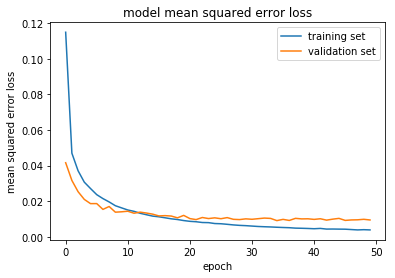

In [20]:
# Visualize
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

In [25]:
nvidia_model().summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_12 (Convolution2D) (None, 24, 80, 24)    1824        convolution2d_input_4[0][0]      
____________________________________________________________________________________________________
convolution2d_13 (Convolution2D) (None, 12, 40, 36)    21636       convolution2d_12[0][0]           
____________________________________________________________________________________________________
convolution2d_14 (Convolution2D) (None, 6, 20, 48)     43248       convolution2d_13[0][0]           
____________________________________________________________________________________________________
convolution2d_15 (Convolution2D) (None, 3, 10, 64)     27712       convolution2d_14[0][0]           
___________________________________________________________________________________________